# **Lab 3: Jetson Setup, GPIO control, and Running YOLOv8 on Jetson**

The lab is designed to get students familiar with NVIDIA Jetson boards. By the end of the lab, students will be able to:
- Set up and configure a NVIDIA Jetson developer kit.  
- Run a simple Python demo script to verify the environment.  
- Control GPIO pins to blink an LED and read distance from an ultrasonic sensor (HC-SR04).
- Deploy and run YOLOv8 object detection on the Jetson using both a dataset and a live webcam.

## Task 1: Jetson Developer Kit Setup
1. Connect a Jetson board to a monitor, keyboard, and mouse.  
2. Log in a Jetson Board using the account information below.
- Account: cmpe6012
- Password: cmpe6012
3. Connect the Jetson board through WiFi using your student account.
4. Build your lab directory
```bash
mkdir -p ~/CMPE6012/STUDENT_ID # Replace STUDENT_ID with your student ID
```
5. Run a Demo Python Script
- Create a Python script `demo.py` in your lab directory `~/CMPE6012/STUDENT_ID` for testing:  
```python
print("Hello from Jetson!")
```
- Run it:  
```bash
python demo.py
```

## Task 2: Blink LED

### 2.1 Jetson Orin Nano Pin Assignment for the 40-pin Expansion Header
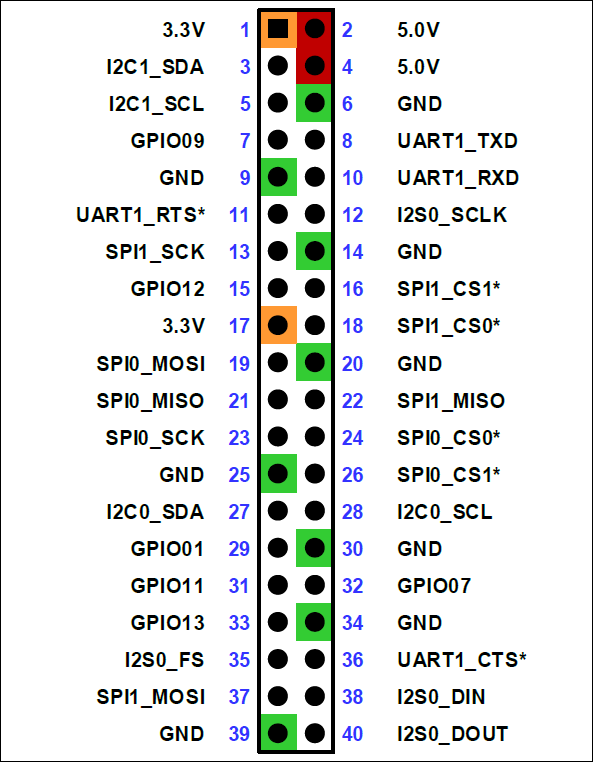

### 2.2 Jetson AGX Orin Pin Assignment for the 40-pin Expansion Header
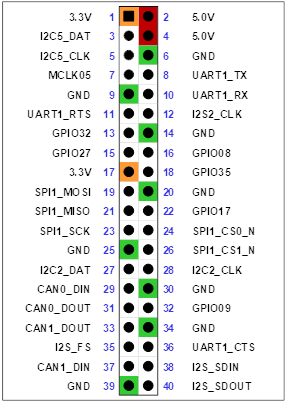

### 2.3 Blink an LED  
- **Wiring:** Build a curcuit as instructed below for controlling an LED with a transistor S9015 through a Jetson GPIO pin (e.g., `GPIO09`).

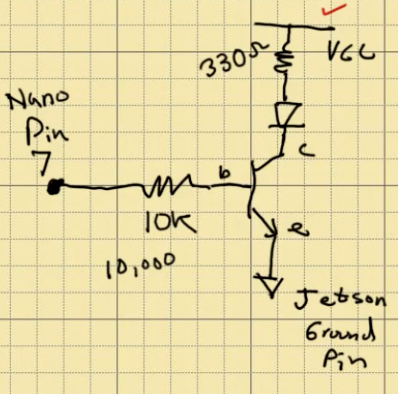
- Create a Python script `blink.py` to in your lab directory `~/CMPE6012/STUDENT_ID` blink the LED:
```python
import Jetson.GPIO as GPIO
import time

LED_PIN = 7 # GPIO09 is Pin 7 on Jetson Orin Nano
GPIO.setmode(GPIO.BOARD)
GPIO.setup(LED_PIN, GPIO.OUT)

print("Blinking LED...")
for i in range(10):
    GPIO.output(LED_PIN, GPIO.HIGH)
    time.sleep(0.5)
    GPIO.output(LED_PIN, GPIO.LOW)
    time.sleep(0.5)

GPIO.cleanup()
```
- Run it:
```bash
python blink.py
```


## Task 3: Run YOLOv8 on Jetson
This task consists of four sub-tasks:
- Run YOLOv8s using CPU with an image file.
- Run YOLOv8s using GPU with an image file.
- Run YOLOv8x using GPU with an image file.
- Run YOLOv8x using GPU with a webcam.

---

### 3.1 Docker Environment Setup for Pytorch on Jetson

Setting up a docker environment on Jetson to run YOLOv8 experiments with PyTorch.

---

#### 3.1.1 Install Docker (Optional)

Jetson comes with Docker support. If not installed, run:
```bash
sudo apt update
sudo apt install -y docker.io
sudo systemctl enable docker
sudo systemctl start docker
```
#### 3.1.2 Install NVIDIA Container Toolkit (Optional)
```bash
sudo apt install -y nvidia-container-toolkit
sudo systemctl restart docker
```
#### 3.1.3 Verify NVIDIA Runtime
```bash
sudo docker run --rm --runtime nvidia -v /usr/bin/tegrastats:/usr/bin/tegrastats nvcr.io/nvidia/l4t-pytorch:r35.2.1-pth2.0-py3 timeout 5s tegrastats
```

#### 3.1.4 Build a Docker Image for YOLOv8
- Create a Dockerfile in your lab directory:
```dockerfile
# Dockerfile for YOLOv8 on Jetson Orin Nano (JetPack 5.1)

# Base image: NVIDIA PyTorch for Jetson (JetPack 5.1 / L4T r35.2.1)
FROM nvcr.io/nvidia/l4t-pytorch:r35.2.1-pth2.0-py3

# Set working directory
WORKDIR /workspace

# Upgrade pip
RUN python3 -m pip install --upgrade pip

# Install YOLOv8 and dependencies
RUN pip install ultralytics onnx onnxruntime

# (Optional) Install JupyterLab for notebooks
RUN pip install jupyterlab

# Set working directory inside container
WORKDIR /workspace

# Set environment variable to avoid OpenMP warnings
ENV OMP_NUM_THREADS=1

# Default command: drop into bash
CMD ["/bin/bash"]
```
- Build the Docker image:
```bash
sudo docker build -t yolov8-STUDENT_ID:jetpack5.1 .
```
#### 3.1.5 Run the Container:
```bash
sudo docker run -it --rm \
    --runtime nvidia \
    --network host \
    --device /dev/video0 \
    --device /dev/gpiochip0 \
    --privileged \
    -v ~/CMPE6012/20820550:/workspace \
    yolov8-20820550:jetpack5.1
```
•	-v ~/CMPE6012/STUDENT_ID:/workspace: Links local folder to container
•	--device /dev/gpiochip0: Provides access to GPIO (adjust device as needed)
•	--privileged: Allows low-level hardware access
•	--network host: For networked experiments if needed

You can now run your code in the container with access connected cameras, and GPIO.
⚠️ Make sure to adjust GPIO device paths (/dev/gpiochip*) according to your Jetson hardware.

### 3.2 Run YOLOv8s using CPU (Task 3.1)
#### 3.2.1 Create and run a Python script `yolov8s_cpu.py` in your lab directory for running YOLOv8s using CPU:
```python
# Import YOLO from ultralytics
from ultralytics import YOLO
import time

# Load the YOLOv8 small model (pretrained on COCO)
model = YOLO("yolov8s.pt")
image_url = ""

# Measure inference time
start_time = time.time()
# Run inference on an example image (URL or local path)
results = model(image_url,
                device='cpu',  # Use CPU for inference
)
end_time = time.time()
total_time = end_time - start_time
print(f"Inference Time Costs: {total_time:.3f} seconds")

# Show and save results
for r in results:
    r.save()  # Saves to 'runs/detect/predict'
```
#### 3.2.2 Expected Detections:
- 1 person  
- 1 tie  
- 3 chairs  
- 1 potted plant  
- 1 TV  
- 1 mouse  
- 1 keyboard  

#### 3.2.3 Observe and record the inference time costs (You will need this for comparison later).

### 3.3 Run YOLOv8s using GPU (Task 3.2)
#### 3.3.1 Create and run a Python script `yolov8s_gpu.py` in your lab directory for running YOLOv8s using GPU:
```python
# Import YOLO from ultralytics
from ultralytics import YOLO
import time

# Load the YOLOv8 small model (pretrained on COCO)
model = YOLO("yolov8s.pt")
image_url = "a.jpg"
# Measure inference time
start_time = time.time()
# Run inference on an example image (URL or local path)
results = model(image_url,
                device=0,  # Use GPU for inference
)
end_time = time.time()
total_time = end_time - start_time
print(f"Inference Time Costs: {total_time:.3f} seconds")

# Show and save results
for r in results:
    r.save()  # Saves to 'runs/detect/predict'
```
#### 3.3.2 Expected Detections:
- 1 person  
- 1 tie  
- 3 chairs  
- 1 potted plant  
- 1 TV  
- 1 mouse  
- 1 keyboard  

#### 3.3.3 Observe and record the inference time costs and compare it to the one in Task 3.1.

### 3.4 Run YOLOv8x using GPU (Task 3.3)
#### 3.4.1 Create and run a Python script `yolov8x_gpu.py` in your lab directory for running YOLOv8x using GPU:
```python
# Import YOLO from ultralytics
from ultralytics import YOLO
import time

# Load the YOLOv8 small model (pretrained on COCO)
model = YOLO("yolov8x.pt")

# Measure inference time
start_time = time.time()
# Run inference on an example image (URL or local path)
results = model("a.jpg",
                device=0,  # Use GPU for inference
)
end_time = time.time()
total_time = end_time - start_time
print(f"Inference Time Costs: {total_time:.3f} seconds")

# Show and save results
for r in results:
    r.save()  # Saves to 'runs/detect/predict'
```
#### 3.4.2 Expected Detections:
- 1 person  
- 1 tie  
- 3 chairs  
- 1 potted plant  
- 1 TV  
- 1 mouse  
- 1 keyboard  

#### 3.4.3 Observe and record the inference time costs and compare it to the one in Task 3.2.

### 3.5 Run YOLOv8x using GPU with a webcam (Task 3.4)
#### 3.5.1 Create and run a Python script `yolov8x_gpu_webcam.py` in your lab directory for running YOLOv8x using GPU with a webcam.
- Revise `yolov8x_gpu.py` to process live images from a webcam and count its real-time frame rate and latency.
- You may reuse most of your Python script of live object detection from Lab 3.

#### 3.5.2 Move around the webcam and observe any changes of the real-time frame rate and latency.